In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import numpy as np
import os

## Select base model to apply transfer learning to 
<table style="border: 0px; width: 100%;">
  <th style="border: 0px">
    <tr style="border: 0px; font-weight: bold">
      <td style="border: 0px">Model Name</td>
      <td style="border: 0px">Input Size</td>
      <td style="border: 0px">Data Range</td>
      <td style="border: 0px">Total Params</td>
    </tr>
  </th>
  <tbody>
    <tr style="border: 0px">
      <td style="border: 0px">InceptionResNet2</td>
      <td style="border: 0px">299x299x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">56M</td>
    </tr>
    <tr style="border: 0px">
      <td style="border: 0px">Xception</td>
      <td style="border: 0px">150x150x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">23M</td>
    </tr>
  </tbody>
  
</table>

In [2]:
image_shape = (299, 299, 3)
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=image_shape,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

### Define random data augmentation function

In [3]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.1)], 
    name="data_augmentation"
)

In [4]:
# Create new model on top
inputs = keras.Input(shape=image_shape, name="image_input")
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Inception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1, name="rescale")
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(7)(x)  # Number of emotions to be predicted 
model = keras.Model(inputs, outputs, name="AffectNN")
model.summary()

Model: "AffectNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 299, 299, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 299, 299, 3)       0         
 ial)                                                            
                                                                 
 rescale (Rescaling)         (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                          

# Import the dataset to train the images

In [5]:
base_path_structured = "/Users/benhoskings/Documents/Datasets/Fusion"
train_path_structured = os.path.join(base_path_structured, "train_set")

class_names = ["Anger", "Disgust", "Happy", "Neutral", "Fear", "Sad", "Surprise"]
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path_structured, 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred", 
    validation_split=0.05, 
    subset="both", 
    batch_size=batch_size,
    image_size=(299, 299),
    seed=101)

Found 40621 files belonging to 7 classes.
Using 38590 files for training.
Using 2031 files for validation.


## Display a selectio of the images, with their labels

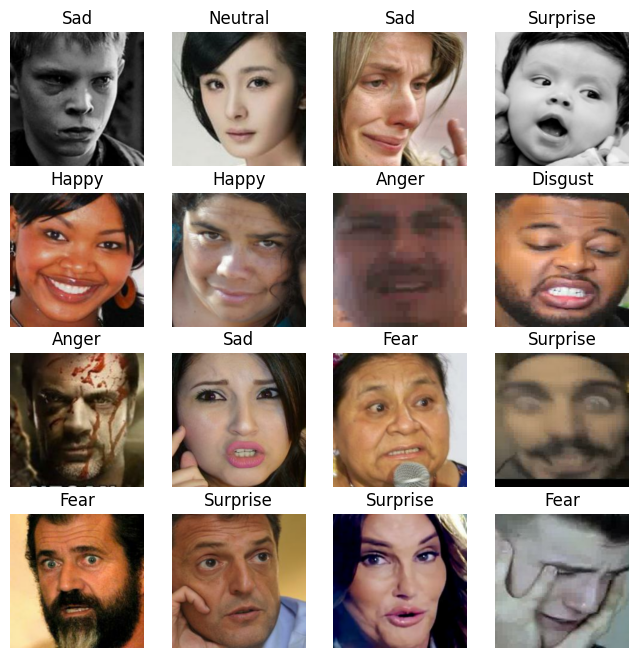

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

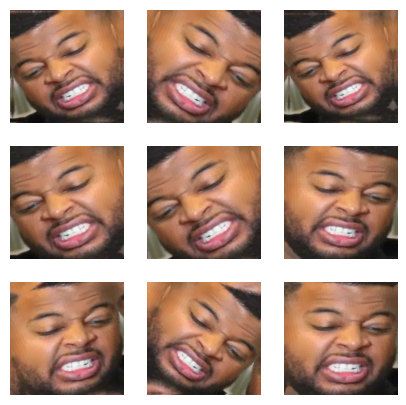

In [7]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1).cache():
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [8]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
# SPECIFY LEARNING RATE
base_learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

total_epochs = 10

In [10]:
checkpoint_filepath = '/Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective-computing/data/checkpoints/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True, 
    save_freq="epoch")

In [11]:
train_history = model.fit(train_ds, epochs=total_epochs, validation_data=validation_ds,
                          callbacks=[model_checkpoint_callback])

Epoch 1/10
302/302 [==============================] - 2119s 7s/step - loss: 0.3939 - categorical_accuracy: 0.2928 - val_loss: 0.3798 - val_categorical_accuracy: 0.3235
Epoch 2/10
302/302 [==============================] - 2030s 7s/step - loss: 0.3665 - categorical_accuracy: 0.3694 - val_loss: 0.3695 - val_categorical_accuracy: 0.3535
Epoch 3/10
302/302 [==============================] - 1835s 6s/step - loss: 0.3594 - categorical_accuracy: 0.3878 - val_loss: 0.3639 - val_categorical_accuracy: 0.3634
Epoch 4/10
302/302 [==============================] - 1999s 7s/step - loss: 0.3545 - categorical_accuracy: 0.3996 - val_loss: 0.3627 - val_categorical_accuracy: 0.3712
Epoch 5/10
302/302 [==============================] - 4249s 14s/step - loss: 0.3519 - categorical_accuracy: 0.4080 - val_loss: 0.3588 - val_categorical_accuracy: 0.3806
Epoch 6/10
302/302 [==============================] - 1814s 6s/step - loss: 0.3498 - categorical_accuracy: 0.4128 - val_loss: 0.3541 - val_categorical_accuracy

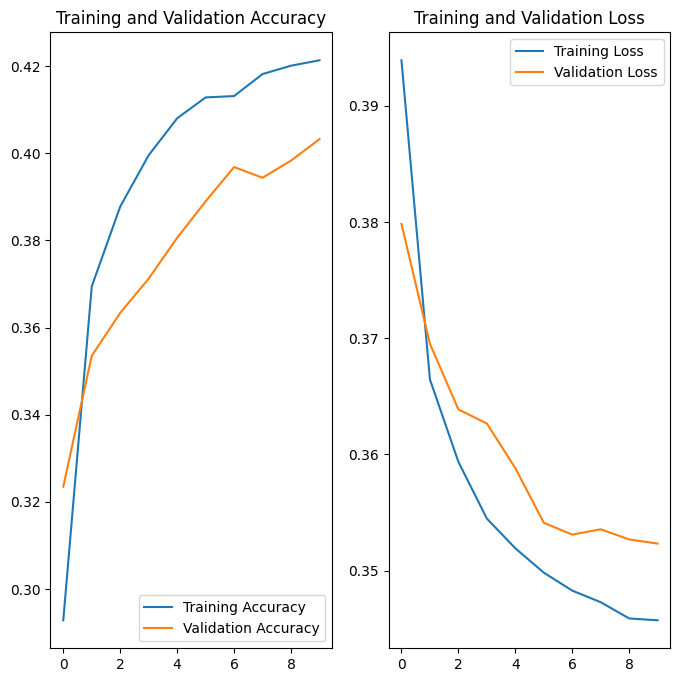

In [12]:
acc = train_history.history['categorical_accuracy']
val_acc = train_history.history['val_categorical_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
def edit_trainable_layers(count,  mod):
    mod.trainable = True
    for layer in base_model.layers[:len(mod.layers) - count]:
      layer.trainable = False
        
    print("Number of trainable variables in the base model: ", len(mod.trainable_variables))

In [14]:
fine_tune_epochs = 10

for l_count in [20, 30, 40]:
    edit_trainable_layers(l_count, base_model)
        
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=base_learning_rate/(l_count*10)),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    total_epochs += fine_tune_epochs
    
    train_history = model.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=train_history.epoch[-1],
                             validation_data=val_ds,
                             callbacks=[model_checkpoint_callback])
    
    acc += train_history.history['categorical_accuracy']
    val_acc += train_history.history['val_categorical_accuracy']
    
    loss += train_history.history['loss']
    val_loss += train_history.history['val_loss']

Number of trainable variables in the base model:  12
Epoch 10/20
302/302 [==============================] - 1931s 6s/step - loss: 0.3405 - categorical_accuracy: 0.4319 - val_loss: 0.3387 - val_categorical_accuracy: 0.4303
Epoch 11/20
302/302 [==============================] - 1926s 6s/step - loss: 0.3360 - categorical_accuracy: 0.4406 - val_loss: 0.3345 - val_categorical_accuracy: 0.4353
Epoch 12/20
302/302 [==============================] - 1926s 6s/step - loss: 0.3301 - categorical_accuracy: 0.4503 - val_loss: 0.3300 - val_categorical_accuracy: 0.4436
Epoch 13/20
302/302 [==============================] - 1989s 7s/step - loss: 0.3264 - categorical_accuracy: 0.4609 - val_loss: 0.3258 - val_categorical_accuracy: 0.4540
Epoch 14/20
302/302 [==============================] - 1999s 7s/step - loss: 0.3222 - categorical_accuracy: 0.4674 - val_loss: 0.3221 - val_categorical_accuracy: 0.4599
Epoch 15/20
302/302 [==============================] - 1924s 6s/step - loss: 0.3175 - categorical_accu

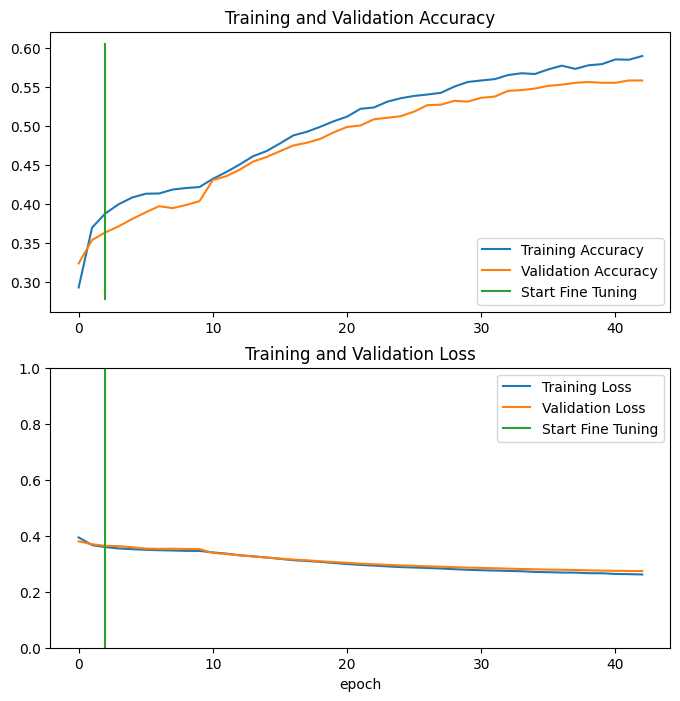

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([2,2], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([2,2], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
img = tf.keras.utils.load_img("sample_images/anger-01.png", target_size=(299, 299))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 148ms/step
This image most likely belongs to Disgust with a 58.90 percent confidence.


In [17]:
model.save("data/AffectInceptionResNetV2.keras")